# Machine Learning and Content Analytics – Mini Project

# Offensive language and hate speech detection 
---
> Students: `Arkoumani Georgia - p2822104` `Poulou Myrto - p2822129` `Koutsodimitropoulou Anastasia - p2822119` `Zaragka Eftychia - p2822112` <br />
> Professor: Haris Papageorgiou (xaris@ilsp.gr) <br />
> Assistant responsible for this assignment: George Perakis (gperakis@aueb.gr) <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> Date: 28/08/2022

* Import all the required libraries

In [ ]:
from google.colab import drive

import warnings

warnings.filterwarnings("ignore")

#from glob import glob

from imblearn.over_sampling._smote.base import Counter
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tqdm import tqdm

from keras.layers import (Embedding, Flatten, Dense,
                          Dropout, Activation, LSTM,
                          Bidirectional, BatchNormalization,
                          Conv1D, GlobalMaxPooling1D, SpatialDropout1D,
                          MaxPooling1D)

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

#from google.colab import files

# Preparation
Before proceeding with the steps described in the upcoming sections, create in Google Drive a folder named "MLCA_Datasets". Over there, there store:

*   more_cleaned_df.csv
*   glove.6B.100d.txt
*   glove.6B.300d.txt



# Load Data

Unzip and load the "more_cleaned_df.csv"

In [ ]:
#Establish connection with Google Drive:
drive.mount('/content/drive', force_remount=True) #access Google Drive

!unzip -u "/content/drive/My Drive/MLCA_Datasets/more_cleaned_df.zip" -d "/content/drive/My Drive/folder/MLCA_Datasets"

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/MLCA_Datasets/" #access the folder

'''
#Alternate way of data load:

uploaded = files.upload()

!unzip "more_cleaned_df.zip"
cleaned_df = pd.read_csv('more_cleaned_df.csv')
'''

#Load csv file
df = pd.read_csv(data_path + "more_cleaned_df.csv", sep=',')
#df

# Choose a random sample of 500.000 records
import random
pull = 500000
i_sample = random.choices(range(len(df)), k=pull)
df = df.iloc[i_sample]

In [ ]:
# Check if the data are imbalanced:

df.groupby('category').count()

,lemmatized
category,
0,481776
1,18224


# Data Pre-Processing


In [ ]:
#Find max number of words:

word_freqs = nltk.FreqDist(df.lemmatized.str.split(" ").sum())

max_words = len(word_freqs) # Consider the length of word_freqs as the most used words in the dataset

# Setting up Keras tokenizer, in order to vectorize a text corpus, 
# by turning each text into a sequence of integers:

comments_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
comments_tokenizer

In [ ]:
# Generate tokens by counting frequency:
comments_tokenizer.fit_on_texts(df['lemmatized'])

In [ ]:
# With the following action, the text turns intro sequence of numbers:
sequences = comments_tokenizer.texts_to_sequences(df['lemmatized'])

In [ ]:
# The tokenizers word_index is a dictionary that maps each word to a number:
word_index = comments_tokenizer.word_index

In the next step it was rather important to identify what would be the max sequence of all the comments (in order to proceed with their padding). In order to achieve that, it was first important to conduct the distribution of the 'lemmatized' column, and identify the cumulative percent of text.

In [ ]:
# calculate the distribution:
dist_text_len = df['lemmatized'].str.split(" ").apply(len).value_counts(normalize=True).sort_index()

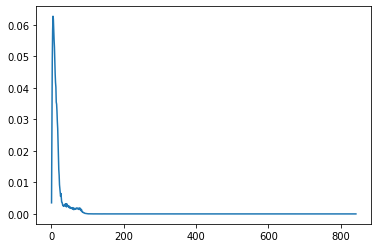

In [ ]:
# plot the distribution:
dist_text_len.plot()

In [ ]:
# cumulative percent of text that contains 90 characters:
dist_text_len.iloc[:90].sum()

0.99644

In [ ]:
# Make all sequences 90 characters long (all text sequences we feed into the models
# have the same length)
maxlen = 90

# This is achieved with the Keras pad sequences tool.
# It cuts of sequences that are too long and adds zeros to sequences that are too short.
data = pad_sequences(sequences, maxlen=maxlen)

# There are 500.000, 90 characters sequences now
print('New data shape: {}'.format(data.shape))

New data shape: (500000, 90)


# Data Shuffling, SMOTE & Train-Test-Validation Split

In [ ]:
# turn all data into proper training and validation data:
category = np.asarray(df['category'])

In [ ]:
# Shuffling data

# Using the length of the texts indexes are created
# numpy's range() function. eg array([0, 1, 2, 3, 4, 5])
indices = np.arange(data.shape[0])

# The indices are shuffled on the fly, eg: array([3, 0, 1, 4, 2, 5])
np.random.shuffle(indices)

data = data[indices]  # get the shuffled texts
category = category[indices]  # and the shuffled sentiments

In [ ]:
training_samples = 400000 #80% of the dataset

# Split data
#Train data are the 80% of the dataset
x_train = data[:training_samples]
y_train = category[:training_samples]

#The rest 20% refers to the test data:
x_test = data[training_samples:]
y_test = category[training_samples:]

#The validation data consist of a 10% of the train data:
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, 
                                                   test_size=0.1, random_state=1001)

#Print the shapes of the train-test-validation data:
print(f'x train shape: {x_train.shape}')
print(f'y train shape: {y_train.shape}')

print(f'x val shape: {x_val.shape}')
print(f'y val shape: {y_val.shape}')

print(f'x test shape: {x_test.shape}')
print(f'y test shape: {y_test.shape}')

x train shape: (360000, 90)
y train shape: (360000,)
x val shape: (40000, 90)
y val shape: (40000,)
x test shape: (100000, 90)
y test shape: (100000,)


In [ ]:
# Perform SMOTE in order to have an equal amount of data with category 0 and category 1
# since the data are imbalanced:

counter = Counter(y_train) #check the number of records in each category before SMOTE
print('Before', counter)

#Perform SMOTE in the train data
smt=SMOTE()
x_train, y_train = smt.fit_resample(x_train, y_train)

counter = Counter(y_train) #check the number of records in each category after SMOTE
print('After', counter)

Before Counter({0: 346996, 1: 13004})
After Counter({1: 346996, 0: 346996})


# GloVe Embeddings
It was decided to use pre-trained word embeddings (GloVe Embeddings is one of them). In order to use the GloVe Embeddings, the folder glove.6B.zip was downloaded from the Stanford website (https://nlp.stanford.edu/projects/glove/). After the folder was successfully downloaded, the embeddings were loaded into the model.

In [ ]:
# Create a function named 'glove_embeddings' which loads the glove embeddings
# It receives as parameters the embeddings size (dimensions)
def load_glove_embeddings(dim: int = 100) -> dict:

    print('Loading word vectors')

    embed_index = dict()  # Create a dictionary of word -> embedding

    path = "/content/drive/My Drive/MLCA_Datasets" #access the folder under which the embeddings files exist
    fname = f'{path}/glove.6B.{dim}d.txt' #the file of the 100 dimensions is selected

    f = open(fname, encoding="utf8")  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close() #close file

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [ ]:
embedding_dim = 300  # Now larger embeddings are used

embeddings_index = load_glove_embeddings(dim=embedding_dim)

Loading word vectors


Loading Embeddings: 400000word [00:31, 12817.45word/s]

Found 400000 word vectors.


In [ ]:
# Check the shape of the word 'the'
embeddings_index['the'].shape

(300,)

After the above actions are performed, it is important to note that in our vocabulary not all words might be in the GloVe embedding. As a result, for missing words it is wise to use random embeddings with the same mean and standard deviation as the GloVe Embeddings.

In order to achieve this, the following actions were performed:

In [ ]:
# Create a function named 'create_embeddings_matrix' which receives as parameters the following:
# emb_index: Embeddings Index
# tokenizer: Keras fitted tokenizer.
# emb_dim: Embeddings dimension.
# return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # Create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [ ]:
#create the embedding_matrix:
embedding_matrix = create_embeddings_matrix(emb_index=embeddings_index,
                                            tokenizer=comments_tokenizer,
                                            emb_dim=embedding_dim)

Embeddings AVG: -0.003905011573806405 | STD: 0.3817702829837799
Found 14576 pre-trained embeddings out of 15000


It is important to mention that the embedding matrix will be used as weights for the embedding layer.

In [ ]:
max_num_categories=2 #set maximum number of categories equal to 2

labeltrain = to_categorical(y_train, num_classes=max_num_categories)
labelval = to_categorical(y_val, num_classes=max_num_categories)
labeltest = to_categorical(y_test, num_classes=max_num_categories)

# Build RNN model

In [ ]:
RNN_model = Sequential() #create a sequential model

#Build LSTM model with Embedding
embedding_layer = Embedding(max_words, embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=maxlen, trainable=False)

RNN_model.add(embedding_layer)
RNN_model.add(SpatialDropout1D(0.1))

#Build LSTM
RNN_model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
RNN_model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
RNN_model.add(GlobalMaxPooling1D())

#Build Dense layers:
RNN_model.add(Dense(16, activation='relu'))
RNN_model.add(Dropout(0.1))
RNN_model.add(Dense(2, activation='softmax'))

print(RNN_model.summary()) # print the model summary

# Compile the model
# Notice that we now have far fewer trainable parameters.
RNN_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 90, 300)           4500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 90, 300)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 90, 64)           85248     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 90, 32)           10368     
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                         

In [ ]:
# Fit the model with 30 epochs and 256 batch_size:
RNN_history = RNN_model.fit(x_train, labeltrain,
                       epochs=30,
                       batch_size=256,
                       validation_data=(x_val, labelval),
                       callbacks=[EarlyStopping(patience=2)]) #with the EarlyStopping the code will terminate earlier than 30 epochs if the val_acc does not differ significantly from epoch to epoch.

Epoch 1/30
2712/2712 [==============================] - 4419s 2s/step - loss: 0.4053 - acc: 0.8030 - val_loss: 0.3440 - val_acc: 0.8402
Epoch 2/30
2712/2712 [==============================] - 4447s 2s/step - loss: 0.3210 - acc: 0.8526 - val_loss: 0.3172 - val_acc: 0.8577
Epoch 3/30
2712/2712 [==============================] - 4392s 2s/step - loss: 0.2971 - acc: 0.8652 - val_loss: 0.3215 - val_acc: 0.8554
Epoch 4/30
2712/2712 [==============================] - 4332s 2s/step - loss: 0.2829 - acc: 0.8731 - val_loss: 0.2777 - val_acc: 0.8802
Epoch 5/30
2712/2712 [==============================] - 4337s 2s/step - loss: 0.2732 - acc: 0.8780 - val_loss: 0.3036 - val_acc: 0.8646
Epoch 6/30
2712/2712 [==============================] - 4330s 2s/step - loss: 0.2658 - acc: 0.8819 - val_loss: 0.2548 - val_acc: 0.8947
Epoch 7/30
2712/2712 [==============================] - 4314s 2s/step - loss: 0.2598 - acc: 0.8850 - val_loss: 0.2967 - val_acc: 0.8672
Epoch 8/30
2712/2712 [==========================

In [ ]:
#check the test score
score = RNN_model.evaluate(
    x_test,                  # features
    labeltest,                  # labels
    #batch_size=32,           # batch size
    verbose=1                # the most extended verbose
)

#print results:
print('\nTest binary_crossentropy:', score[0])
print('\nTest accuracy:', score[1])

3125/3125 [==============================] - 184s 59ms/step - loss: 0.2813 - acc: 0.8778

Test binary_crossentropy: 0.28125542402267456

Test accuracy: 0.877780020236969


The next step in the process was to visualize the results. Two plots were created; one plot displays the training-validation accuracy and the second plot displays the training-validation loss.

Text(0.5, 1.0, 'Training and Validation Loss')

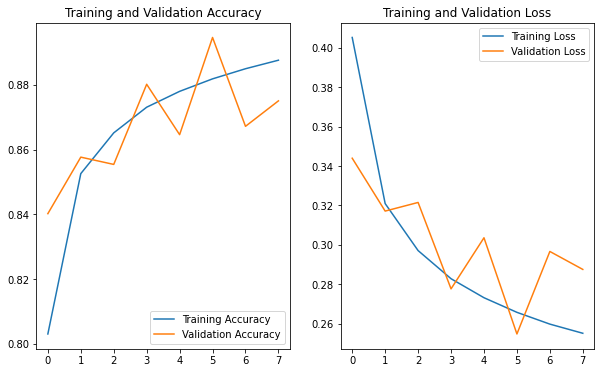

In [ ]:
acc = RNN_history.history['acc']
val_acc = RNN_history.history['val_acc']

loss = RNN_history.history['loss']
val_loss = RNN_history.history['val_loss']

epochs_range = RNN_history.epoch

plt.figure(figsize=(10, 6)) #set the size of the plots
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) #plots will be displayed next to each other
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
RNN_model.save_weights("RNN.hdf5") #save model weights
RNN_model.save("RNN") #save model

# Build CNN Model

In [ ]:
CNN_model = Sequential() # create a sequential model

# Build an embedding layer:
embedding_layer = Embedding(max_words, embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=maxlen, trainable=False)
CNN_model.add(embedding_layer)
CNN_model.add(SpatialDropout1D(0.1))

# add a convolutional layer & pooling operation:
CNN_model.add(Conv1D(256, 3, activation='relu', padding="same"))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv1D(256, 3, activation='relu', padding="same"))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling1D())
CNN_model.add(Dropout(0.1))

# add a second convolutional layer
CNN_model.add(Conv1D(128, 3, activation='relu', padding="same"))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv1D(128, 3, activation='relu', padding="same"))
CNN_model.add(BatchNormalization())
CNN_model.add(GlobalMaxPooling1D())
CNN_model.add(Dropout(0.1))

# Build dense layers
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.1))


CNN_model.add(Dense(2, activation='softmax'))

print(CNN_model.summary()) #print model's summary

# Compile the model
# Notice that we now have far fewer trainable parameters.
CNN_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 90, 300)           4500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 90, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 90, 256)           230656    
                                                                 
 batch_normalization (BatchN  (None, 90, 256)          1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 256)           196864    
                                                                 
 batch_normalization_1 (Batc  (None, 90, 256)          1

In [ ]:
# Fit the model with 30 epochs and 256 batch_size:
CNN_history = CNN_model.fit(x_train, labeltrain,
                       epochs=30,
                       batch_size=256,
                       validation_data=(x_val, labelval),
                       callbacks=[EarlyStopping(patience=2)]) #with the EarlyStopping the code will terminate earlier than 30 epochs if the val_acc does not differ significantly from epoch to epoch.

Epoch 1/30
2711/2711 [==============================] - 4505s 2s/step - loss: 0.4090 - acc: 0.7980 - val_loss: 0.3497 - val_acc: 0.8415
Epoch 2/30
2711/2711 [==============================] - 4490s 2s/step - loss: 0.2927 - acc: 0.8686 - val_loss: 0.3443 - val_acc: 0.8263
Epoch 3/30
2711/2711 [==============================] - 4727s 2s/step - loss: 0.2579 - acc: 0.8871 - val_loss: 0.3368 - val_acc: 0.8394
Epoch 4/30
2711/2711 [==============================] - 4484s 2s/step - loss: 0.2344 - acc: 0.8987 - val_loss: 0.2004 - val_acc: 0.9213
Epoch 5/30
2711/2711 [==============================] - 4509s 2s/step - loss: 0.2156 - acc: 0.9081 - val_loss: 0.3056 - val_acc: 0.8741
Epoch 6/30
2711/2711 [==============================] - 4480s 2s/step - loss: 0.1997 - acc: 0.9158 - val_loss: 0.2288 - val_acc: 0.9052


In [ ]:
#check the test score of the model:
score = CNN_model.evaluate(
    x_test,                  # features
    labeltest,                  # labels
    #batch_size=32,   # batch size
    verbose=1                # the most extended verbose
)

# print the results:
print('\nTest binary_crossentropy:', score[0])
print('\nTest accuracy:', score[1])

3125/3125 [==============================] - 199s 64ms/step - loss: 0.2260 - acc: 0.9064

Test binary_crossentropy: 0.2260001301765442

Test accuracy: 0.9064199924468994


The next step in the process was to visualize the results. Two plots were created; one plot displays the training-validation accuracy and the second plot displays the training-validation loss.

Text(0.5, 1.0, 'Training and Validation Loss')

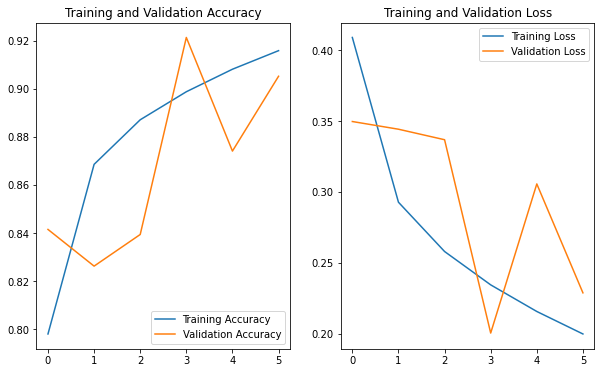

In [ ]:
acc = CNN_history.history['acc']
val_acc = CNN_history.history['val_acc']

loss = CNN_history.history['loss']
val_loss = CNN_history.history['val_loss']

epochs_range = CNN_history.epoch

plt.figure(figsize=(10, 6)) #set the size of the plots
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) #plots will be displayed next to each other
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
CNN_model.save_weights("CNN.hdf5") #save model weights
CNN_model.save("CNN") #save model

# Confusion Matrix

In [ ]:
# extract the predicted probabilities
p_pred = RNN_model.predict(x_test)
p_pred = p_pred.flatten()
print(p_pred.round(2))

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[0.26 0.74 1.   ... 0.   1.   0.  ]
[0 1 1 ... 0 1 0]


# Honor Code
Parts of code have been extracted from the code files "a_embeddings.ipynb" (source: https://e-mscba.dmst.aueb.gr/pluginfile.php/4978/mod_folder/content/0/a_embeddings.ipynb?forcedownload=1)